Install necessary libraries `scipy` for scientific computing, `seaborn` for data visualization capabilities, and `lazypredict` to evaluate classifiers

In [ ]:
# Install Required Libraries
!pip install scipy seaborn lazypredict

Mount Google Drive to access the data files stored there

In [ ]:
# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the required libraries. `numpy` for numerical operations, `scipy.io` for loading MATLAB files, `sklearn` for machine learning model creation, training, and evaluation, `matplotlib.pyplot` and `seaborn` for data visualization, and `lazypredict` to evaluate classifiers

In [ ]:
# Import necessary libraries
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler

Load the coherence data from a MATLAB (.mat) file stored in Google Drive. It contains the PLV matrices for Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD), and Healthy Controls (HC). Use `scipy.io.loadmat` to read the .mat file

In [ ]:
# Load the coherence data from .mat file
mat_file_path = '/content/drive/MyDrive/GNN_Approach/Data_files/Coherence.mat'
mat = scipy.io.loadmat(mat_file_path)
coherence_data = mat['Coherence'][0, 0]

Extract the Coherence data for different categories: Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD), and Healthy Controls (HC)

In [ ]:
# Extracting data in different categories (AZ, FTD, HC)
coherence_AZ_F = coherence_data['AZ']
coherence_FTD_F = coherence_data['FTD']
coherence_HC_F = coherence_data['HC']

Extract the data corresponding to the 3rd frequency band (index 2) and then reshape the extracted data

In [ ]:
# Extract the 3rd frequency band (index 2)
coherence_AZ = coherence_AZ_F[:, 2, :].reshape(2346, 1, 36)
coherence_FTD = coherence_FTD_F[:, 2, :].reshape(2346, 1, 23)
coherence_HC = coherence_HC_F[:, 2, :].reshape(2346, 1, 29)


# Optional: To test whether the data is converted properly into numpy arrays
print(coherence_AZ.shape)
print(coherence_FTD.shape)
print(coherence_HC.shape)

(2346, 1, 36)
(2346, 1, 23)
(2346, 1, 29)


Reconstructs the coherence matrix from the extracted PLV data. The function iterates over frequency bands and subjects, creating a 68x68 matrix with coherence values. The rebuilt matrices are stored in a 4D array with dimensions corresponding to regions, regions, bands, and subjects.

In [ ]:
# Function to rebuild the coherence matrix from the coherence data
def rebuild_matrix(coherence_data):
    n_regions = 68
    n_data = coherence_data.shape[2]
    n_bands = coherence_data.shape[1]

    rebuilt_data = np.zeros((n_regions, n_regions, n_bands, n_data))

    for band in range(n_bands):
        for subject in range(n_data):
            matrix = np.zeros((n_regions, n_regions))
            idx = 0
            for col in range(n_regions):
                for row in range(col + 1):
                    matrix[row, col] = coherence_data[idx, band, subject]
                    idx += 1
            matrix = matrix + matrix.T - np.diag(matrix.diagonal())
            rebuilt_data[:, :, band, subject] = matrix

    return rebuilt_data


Reconstruct the coherence matrices for each category (AZ, FTD, HC) and check the shapes of the resulting matrices to ensure that they have been reconstructed correctly and have the expected dimensions

In [ ]:
# Rebuild the coherence matrices
coherence_AZ_rebuilt = rebuild_matrix(coherence_AZ)
coherence_FTD_rebuilt = rebuild_matrix(coherence_FTD)
coherence_HC_rebuilt = rebuild_matrix(coherence_HC)

# Check the shapes to ensure correctness
print('PLV_AZ_rebuilt shape:', coherence_AZ_rebuilt.shape)
print('PLV_FTD_rebuilt shape:', coherence_FTD_rebuilt.shape)
print('PLV_HC_rebuilt shape:', coherence_HC_rebuilt.shape)

PLV_AZ_rebuilt shape: (68, 68, 1, 36)
PLV_FTD_rebuilt shape: (68, 68, 1, 23)
PLV_HC_rebuilt shape: (68, 68, 1, 29)


Visualize a single coherence matrix using a heatmap. Use `seaborn` for better visual representation. Extract the coherence matrix for the first patient in the AZ category and use the visualization function to plot it, ensuring that the data is ordered correctly.

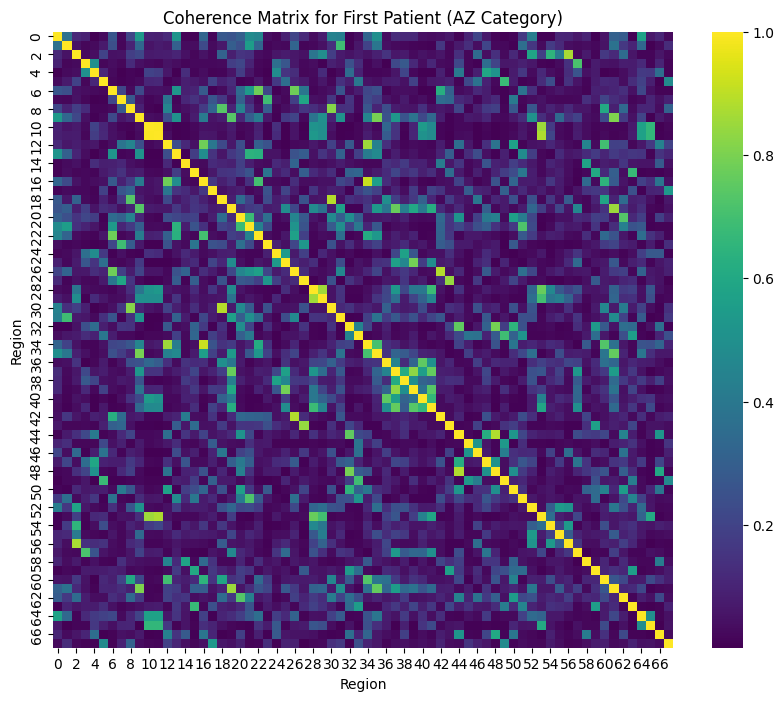

In [ ]:
# Function to visualize a single coherence matrix
def visualize_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap='viridis')
    plt.title(title)
    plt.xlabel('Region')
    plt.ylabel('Region')
    plt.show()

# Extract the coherence matrix for the first patient in the AZ category
single_patient_az_matrix = coherence_AZ_rebuilt[:, :, 0, 0]  # Choosing the first frequency band (index 0)

# Visualize the coherence matrix for the first patient in the AZ category
visualize_matrix(single_patient_az_matrix, 'Coherence Matrix for First Patient (AZ Category)')



Extracts edge features from the coherence matrices and assigns labels to them. The function iterates over the subjects and bands, extracting the upper triangular part of each coherence matrix (excluding the diagonal). These edge attributes are then stored in a feature array, and the corresponding labels are stored in a label array

In [ ]:
# Extract edge features and labels
def extract_edge_features_labels(data, label):
    features = []
    labels = []
    for i in range(data.shape[3]):
        for j in range(data.shape[2]):
            matrix = data[:, :, j, i]
            edge_attr = matrix[np.triu_indices_from(matrix, k=1)]
            features.append(edge_attr)
            labels.append(label)
    return np.array(features), np.array(labels)

Use the `extract_edge_features_labels` function to extract features and labels for different classification tasks:
1. Alzheimer's Disease (AZ) vs. Healthy Controls (HC)
2. Frontotemporal Dementia (FTD) vs. Healthy Controls (HC)
3. Frontotemporal Dementia (FTD) vs. Alzheimer's Disease (AZ)

For each classification task, extract the edge features and labels from the rebuilt coherence matrices and concatenate them to form the complete dataset for each classification task.

In [ ]:
# Extract features and labels for AZ vs HC
features_az_hc, labels_az_hc = extract_edge_features_labels(coherence_HC_rebuilt, 0)
features_az_hc_, labels_az_hc_ = extract_edge_features_labels(coherence_AZ_rebuilt, 2)
features_az_hc = np.concatenate((features_az_hc, features_az_hc_), axis=0)
labels_az_hc = np.concatenate((labels_az_hc, labels_az_hc_), axis=0)

# Extract features and labels for FTD vs HC
features_ftd_hc, labels_ftd_hc = extract_edge_features_labels(coherence_HC_rebuilt, 0)
features_ftd_hc_, labels_ftd_hc_ = extract_edge_features_labels(coherence_FTD_rebuilt, 1)
features_ftd_hc = np.concatenate((features_ftd_hc, features_ftd_hc_), axis=0)
labels_ftd_hc = np.concatenate((labels_ftd_hc, labels_ftd_hc_), axis=0)

# Extract features and labels for FTD vs AZ
features_ftd_az, labels_ftd_az = extract_edge_features_labels(coherence_FTD_rebuilt, 1)
features_ftd_az_, labels_ftd_az_ = extract_edge_features_labels(coherence_AZ_rebuilt, 2)
features_ftd_az = np.concatenate((features_ftd_az, features_ftd_az_), axis=0)
labels_ftd_az = np.concatenate((labels_ftd_az, labels_ftd_az_), axis=0)


Split the extracted features and labels into training and testing sets for three classification tasks:
1. Alzheimer's Disease (AZ) vs. Healthy Controls (HC)
2. Frontotemporal Dementia (FTD) vs. Healthy Controls (HC)
3. Frontotemporal Dementia (FTD) vs. Alzheimer's Disease (AZ)

In [ ]:
# Split data into training and testing sets for AZ vs HC
X_train_az_hc, X_test_az_hc, y_train_az_hc, y_test_az_hc = train_test_split(features_az_hc, labels_az_hc, test_size=0.2, random_state=42)

# Split data into training and testing sets for FTD vs HC
X_train_ftd_hc, X_test_ftd_hc, y_train_ftd_hc, y_test_ftd_hc = train_test_split(features_ftd_hc, labels_ftd_hc, test_size=0.2, random_state=42)

# Split data into training and testing sets for FTD vs AZ
X_train_ftd_az, X_test_ftd_az, y_train_ftd_az, y_test_ftd_az = train_test_split(features_ftd_az, labels_ftd_az, test_size=0.2, random_state=42)


Use LazyPredict to find the best classifier for each classification task

In [ ]:
# Use LazyPredict to find the best classifier
def evaluate_lazy_predict(X_train, X_test, y_train, y_test, title):
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    print(f"Model performance for {title}:\n", models)
    return models

Run and Print the models and there performences

In [ ]:
print("Evaluating models for AZ vs HC")
models_az_hc = evaluate_lazy_predict(X_train_az_hc, X_test_az_hc, y_train_az_hc, y_test_az_hc, "AZ vs HC")

print("Evaluating models for FTD vs HC")
models_ftd_hc = evaluate_lazy_predict(X_train_ftd_hc, X_test_ftd_hc, y_train_ftd_hc, y_test_ftd_hc, "FTD vs HC")

print("Evaluating models for FTD vs AZ")
models_ftd_az = evaluate_lazy_predict(X_train_ftd_az, X_test_ftd_az, y_train_ftd_az, y_test_ftd_az, "FTD vs AZ")

Evaluating models for AZ vs HC


 90%|████████▉ | 26/29 [00:07<00:00,  4.64it/s]

[LightGBM] [Info] Number of positive: 28, number of negative: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43276
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 2278
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151
[LightGBM] [Info] Start training from score 0.154151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

100%|██████████| 29/29 [00:08<00:00,  3.61it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 29/29 [00:05<00:00,  5.47it/s]


[LightGBM] [Info] Number of positive: 18, number of negative: 23
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33160
[LightGBM] [Info] Number of data points in the train set: 41, number of used features: 2167
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439024 -> initscore=-0.245122
[LightGBM] [Info] Start training from score -0.245122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

 90%|████████▉ | 26/29 [00:04<00:00,  6.99it/s]

[LightGBM] [Info] Number of positive: 29, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39471
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 2278
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617021 -> initscore=0.476924
[LightGBM] [Info] Start training from score 0.476924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

100%|██████████| 29/29 [00:04<00:00,  6.27it/s]

Model performance for FTD vs AZ:
                                Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreeClassifier                0.67               0.69     0.69      0.67   
BaggingClassifier                  0.58               0.59     0.59      0.59   
AdaBoostClassifier                 0.58               0.56     0.56      0.57   
DecisionTreeClassifier             0.58               0.56     0.56      0.57   
SVC                                0.58               0.50     0.50      0.43   
CalibratedClassifierCV             0.58               0.50     0.50      0.43   
DummyClassifier                    0.58               0.50     0.50      0.43   
LabelPropagation                   0.42               0.50     0.50      0.25   
LabelSpreading                     0.42               0.50     0.50      0.25   
PassiveAggressiveClassifier        0.50               0.49     0.49      0.